# A2: NeuralNetwork Class

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Requirements" data-toc-modified-id="Requirements-1">Requirements</a></span></li><li><span><a href="#Code-for-NeuralNetwork-Class" data-toc-modified-id="Code-for-NeuralNetwork-Class-2">Code for <code>NeuralNetwork</code> Class</a></span></li><li><span><a href="#Example-Results" data-toc-modified-id="Example-Results-3">Example Results</a></span></li><li><span><a href="#Application-to-Boston-Housing-Data" data-toc-modified-id="Application-to-Boston-Housing-Data-4">Application to Boston Housing Data</a></span></li></ul></div>

## Requirements

In this assignment, you will complete the implementation of the `NeuralNetwork` class, starting with the code included in the next code cell.  Your implementation must meet the requirements described in the doc-strings.

Then apply your `NeuralNetwork` class to the problem of predicting the value of houses in Boston as described below.

## Code for `NeuralNetwork` Class

In [ ]:
%%writefile neuralnetwork.py

import numpy as np
import optimizers as opt


class NeuralNetwork():
    """
    A class that represents a neural network for nonlinear regression

    Attributes
    ----------
    n_inputs : int
        The number of values in each sample
    n_hidden_units_by_layers: list of ints, or empty
        The number of units in each hidden layer.
        Its length specifies the number of hidden layers.
    n_outputs: int
        The number of units in output layer
    all_weights : one-dimensional numpy array
        Contains all weights of the network as a vector
    Ws : list of two-dimensional numpy arrays
        Contains matrices of weights in each layer,
        as views into all_weights
    all_gradients : one-dimensional numpy array
        Contains all gradients of mean square error with
        respect to each weight in the network as a vector
    Grads : list of two-dimensional numpy arrays
        Contains matrices of gradients weights in each layer,
        as views into all_gradients
    total_epochs : int
        Total number of epochs trained so far
    error_trace : list
        Mean square error (standardized) after each epoch
    X_means : one-dimensional numpy array
        Means of the components, or features, across samples
    X_stds : one-dimensional numpy array
        Standard deviations of the components, or features, across samples
    T_means : one-dimensional numpy array
        Means of the components of the targets, across samples
    T_stds : one-dimensional numpy array
        Standard deviations of the components of the targets, across samples
        
    Methods
    -------
    make_weights_and_views(shapes)
        Creates all initial weights and views for each layer

    train(X, T, n_epochs, method='sgd', learning_rate=None, verbose=True)
        Trains the network using samples by rows in X and T

    use(X)
        Applies network to inputs X and returns network's output
    """

    def __init__(self, n_inputs, n_hidden_units_by_layers, n_outputs):
        """Creates a neural network with the given structure

        Parameters
        ----------
        n_inputs : int
            The number of values in each sample
        n_hidden_units_by_layers : list of ints, or empty
            The number of units in each hidden layer.
            Its length specifies the number of hidden layers.
        n_outputs : int
            The number of units in output layer

        Returns
        -------
        NeuralNetwork object
        """

        # Assign attribute values. Set self.X_means to None to indicate
        # that standardization parameters have not been calculated.
        # ....
        self.n_inputs = n_inputs
        self.n_hidden_units_by_layers = n_hidden_units_by_layers
        self.n_outputs = n_outputs
        self.total_epochs = 0
        self.error_trace = []
        self.X_means = None
        self.X_stds = None
        self.T_means = None
        self.T_stds = None
        
        # Build list of shapes for weight matrices in each layer
        # ...
        shapes = []
        if n_hidden_units_by_layers:
            for n in range(len(n_hidden_units_by_layers)):
                if n == 0:
                    shapes.append((1 + n_inputs, n_hidden_units_by_layers[n]))
                else:
                    shapes.append((1 + n_hidden_units_by_layers[n-1], n_hidden_units_by_layers[n]))

            shapes.append((1 + n_hidden_units_by_layers[len(n_hidden_units_by_layers)-1], n_outputs))
        else:
            # no hidden layers, i.e. empty list passed in for n_hidden_units_by_layers
            shapes.append((1 + n_inputs, n_outputs))
        
        # Call make_weights_and_views to create all_weights and Ws
        # ...
        self.all_weights, self.Ws = self.make_weights_and_views(shapes)
        
        # Call make_weights_and_views to create all_gradients and Grads
        # ...
        self.all_gradients, self.Grads = self.make_weights_and_views(shapes)


    def make_weights_and_views(self, shapes):
        """Creates vector of all weights and views for each layer

        Parameters
        ----------
        shapes : list of pairs of ints
            Each pair is number of rows and columns of weights in each layer

        Returns
        -------
        Vector of all weights, and list of views into this vector for each layer
        """

        # Create one-dimensional numpy array of all weights with random initial values
        #  ...
        array_size = 0
        for shape in shapes:
            array_size += (shape[0] * shape[1])
        all_weights = np.random.uniform(-1, 1, size=array_size)
        
        index = 0
        new_index = 0
        for shape in shapes:
            new_index += (shape[0] * shape[1])
            all_weights[index:new_index] = all_weights[index:new_index] / shape[0]
            index = new_index
        # Build list of views by reshaping corresponding elements
        # from vector of all weights into correct shape for each layer.        
        # ...
        #TODO make sure division makes sense / np.sqrt(shapes[0]
        
        views = []
        index = 0
        new_index = 0
        for shape in shapes:
            new_index += (shape[0] * shape[1])
            views.append(all_weights[index:new_index].reshape(shape[0], shape[1]))
            index = new_index
            
            
             
        return all_weights, views
                      
                      
    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, ' + \
            f'{self.n_hidden_units_by_layers}, {self.n_outputs})'

    def __str__(self):
        s = self.__repr__()
        if self.total_epochs > 0:
            s += f'\n Trained for {self.total_epochs} epochs.'
            s += f'\n Final standardized training error {self.error_trace[-1]:.4g}.'
        return s
 
    def train(self, X, T, n_epochs, method='sgd', learning_rate=None, verbose=True):
        """Updates the weights 

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  x  number of input components
        T : two-dimensional numpy array
            number of samples  x  number of output components
        n_epochs : int
            Number of passes to take through all samples
        method : str
            'sgd', 'adam', or 'scg'
        learning_rate : float
            Controls the step size of each update, only for sgd and adam
        verbose: boolean
            If True, progress is shown with print statements
        """

        # Calculate and assign standardization parameters
        # ...


            
        self.X_means = X.mean(axis=0)
        self.X_stds = X.std(axis=0)
        self.T_means = T.mean(axis=0)
        self.T_stds = T.std(axis=0)
        
        # Standardize X and T
        # ...
        XS = (X - self.X_means) / self.X_stds
        TS = (T - self.T_means) / self.T_stds
        
        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = opt.Optimizers(self.all_weights)
        error_convert_f = lambda err: (np.sqrt(err) * self.T_stds)[0]
        # Call the requested optimizer method to train the weights.

        if method == 'sgd':
            
            error_trace = optimizer.sgd(self.error_f, self.gradient_f, [XS, TS], n_epochs, learning_rate, verbose,
               error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f, [XS, TS], n_epochs, learning_rate, verbose,
               error_convert_f=error_convert_f)

        elif method == 'scg':

            error_trace = optimizer.scg(self.error_f, self.gradient_f, [XS, TS], n_epochs, error_convert_f, verbose)

        else:
            raise Exception("method must be 'sgd', 'adam', or 'scg'")

        self.total_epochs += len(error_trace)
        self.error_trace += error_trace

        # Return neural network object to allow applying other methods
        # after training, such as:    Y = nnet.train(X, T, 100, 0.01).use(X)

        return self

    def _forward(self, X):
        """Calculate outputs of each layer given inputs in X
        
        Parameters
        ----------
        X : input samples, standardized

        Returns
        -------
        Outputs of all layers as list
        """
        self.Ys = [X]
        
        # Append output of each layer to list in self.Ys, then return it.
        # ...
        #Also, need to add back in the sum for self.Ws[i][0:1, :])
        if self.n_hidden_units_by_layers:
            Z = np.tanh((X @ self.Ws[0][1:, :]) + self.Ws[0][0:1, :])
            self.Ys.append(Z)
            for i in range(len(self.Ws)-2):
                Z = np.tanh((self.Ys[i + 1] @ self.Ws[i + 1][1:, :]) + self.Ws[i + 1][0:1, :])
                self.Ys.append(Z)
        # Output layer
        Z = (self.Ys[-1] @ self.Ws[-1][1:, :]) + self.Ws[-1][0:1, :]
        self.Ys.append(Z)
        return self.Ys
    
    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        """Calculate output of net and its mean squared error 

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  x  number of input components
        T : two-dimensional numpy array
            number of samples  x  number of output components

        Returns
        -------
        Mean square error as scalar float that is the mean
        square error over all samples
        """
        # Call _forward, calculate mean square error and return it.
        # ...
        return np.mean((T - self._forward(X)[-1]) ** 2)

#     Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        """Returns gradient wrt all weights. Assumes _forward already called.

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  x  number of input components
        T : two-dimensional numpy array
            number of samples  x  number of output components

        Returns
        -------
        Vector of gradients of mean square error wrt all weights
        """

        # Assumes forward_pass just called with layer outputs saved in self.Ys.
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        n_layers = len(self.n_hidden_units_by_layers) + 1

        # D is delta matrix to be back propagated, only need division and negative on first step
        D = -(T - self.Ys[-1]) / (n_samples * n_outputs)
        # Step backwards through the layers to back-propagate the error (D)
        for layeri in range(n_layers - 1, -1, -1):
            
            # gradient of all but bias weights
            self.Grads[layeri][1:, :] = self.Ys[layeri].T @ D
            # gradient of just the bias weights
            self.Grads[layeri][0:1, :] = np.sum(D, axis=0)
            # Back-propagate this layer's delta to previous layer
            if layeri > 0:
                D = D @ self.Ws[layeri][1:, :].T * (1-self.Ys[layeri]**2)
                    
        return self.all_gradients

    def use(self, X):
        """Return the output of the network for input samples as rows in X

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  x  number of input components, unstandardized

        Returns
        -------
        Output of neural network, unstandardized, as numpy array
        of shape  number of samples  x  number of outputs
        """

        # Standardize X
        # ...
        XS = (X - self.X_means) / self.X_stds
        
        # Unstandardize output Y before returning it
        
        return self._forward(XS)[-1] * self.T_stds + self.T_means

    def get_error_trace(self):
        """Returns list of standardized mean square error for each epoch"""
        return self.error_trace

Overwriting neuralnetwork.py


## Example Results

Here we test the `NeuralNetwork` class with some simple data.  

sgd: Epoch 5000 ObjectiveF=0.53661
sgd: Epoch 10000 ObjectiveF=0.53630
sgd: Epoch 15000 ObjectiveF=0.53613
sgd: Epoch 20000 ObjectiveF=0.53592
sgd: Epoch 25000 ObjectiveF=0.53523
sgd: Epoch 30000 ObjectiveF=0.53497
sgd: Epoch 35000 ObjectiveF=0.53477
sgd: Epoch 40000 ObjectiveF=0.53443
sgd: Epoch 45000 ObjectiveF=0.53345
sgd: Epoch 50000 ObjectiveF=0.45632
Adam: Epoch 5000  qF=0.28031
Adam: Epoch 10000  qF=0.02433
Adam: Epoch 15000  qF=0.02075
Adam: Epoch 20000  qF=0.00933
Adam: Epoch 25000  qF=0.00542
Adam: Epoch 30000  qF=0.00436
Adam: Epoch 35000  qF=0.00403
Adam: Epoch 40000  qF=0.00984
Adam: Epoch 45000  qF=0.00496
Adam: Epoch 50000  qF=0.00352
SCG: Epoch 5000 ObjectiveF=0.00314
SCG: Epoch 10000 ObjectiveF=0.00191
SCG: Epoch 15000 ObjectiveF=0.00171
SCG: Epoch 20000 ObjectiveF=0.00158
SCG: Epoch 25000 ObjectiveF=0.00147
SCG: Epoch 30000 ObjectiveF=0.00139
SCG: Epoch 35000 ObjectiveF=0.00128
SCG: Epoch 40000 ObjectiveF=0.00122
SCG: Epoch 45000 ObjectiveF=0.00116
SCG: Epoch 50000 Ob

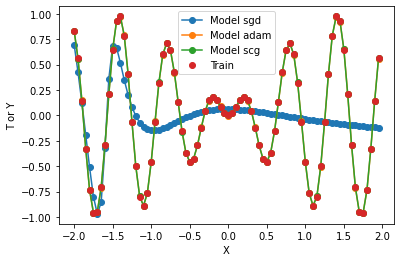

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import neuralnetwork as nn

X = np.arange(-2, 2, 0.05).reshape(-1, 1)
T = np.sin(X) * np.sin(X * 10)

errors = []
n_epochs = 1000
method_rhos = [('sgd', 0.01),
               ('adam', 0.005),
               ('scg', None)]

for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(X.shape[1], [10, 10], 1)
    nnet.train(X, T, 50000, method=method, learning_rate=rho)
    Y = nnet.use(X)
    plt.plot(X, Y, 'o-', label='Model ' + method)
    errors.append(nnet.get_error_trace())

plt.plot(X, T, 'o', label='Train')
plt.xlabel('X')
plt.ylabel('T or Y')
plt.legend();

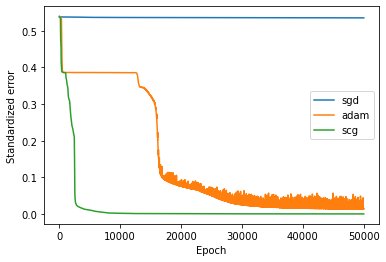

In [3]:
plt.figure(2)
plt.clf()
for error_trace in errors:
    plt.plot(error_trace)
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend([mr[0] for mr in method_rhos]);

In [4]:
import numpy as np
from neuralnetwork import NeuralNetwork
nn = NeuralNetwork(2, [2], 1)
X = np.array([[1,2],
    [4,5],
    [7,8]])
T=np.array([[4],
    [5],
    [6]])
nn.train(X, T, 3,  method='sgd', learning_rate=0.005, verbose=True)
print(nn.use(X))
print(str(nn))
# nn = NeuralNetwork(3, [3], 1)
# X = np.array([[1,2, 3],
#     [4,5,6],
#     [7,8,9]])
# T=np.array([[4],
#     [5],
#     [6]])
# nn.train(X, T, 3,  method='sgd', learning_rate=0.005, verbose=True)

sgd: Epoch 1 ObjectiveF=0.83355
sgd: Epoch 2 ObjectiveF=0.83231
sgd: Epoch 3 ObjectiveF=0.82995
[[5.22321387]
 [5.26851259]
 [5.30611867]]
NeuralNetwork(2, [2], 1)
 Trained for 3 epochs.
 Final standardized training error 0.83.


## Application to Boston Housing Data

Download data from [Boston House Data at Kaggle](https://www.kaggle.com/fedesoriano/the-boston-houseprice-data). Read it into python using the `pandas.read_csv` function.  Assign the first 13 columns as inputs to `X` and the final column as target values to `T`.  Make sure `T` is two-dimensional.

Before training your neural networks, partition the data into training and testing partitions, as shown here.

In [6]:
def partition(X, T, train_fraction):
    n_samples = X.shape[0]
    rows = np.arange(n_samples)
    np.random.shuffle(rows)
    
    n_train = round(n_samples * train_fraction)
    
    Xtrain = X[rows[:n_train], :]
    Ttrain = T[rows[:n_train], :]
    Xtest = X[rows[n_train:], :]
    Ttest = T[rows[n_train:], :]
    return Xtrain, Ttrain, Xtest, Ttest
def rmse(T, Y):
    return np.sqrt(np.mean((T - Y)**2))

Write and run code using your NeuralNetwork class to model the Boston housing data. Experiment with all three optimization methods and a variety of neural network structures (numbers of hidden layer and units), learning rates, and numbers of epochs. Show results for at least three different network structures, learning rates, and numbers of epochs for each method. Show your results using print statements that include the method, network structure, number of epochs, learning rate, and RMSE on training data and RMSE on testing data.

Try to find good values for the RMSE on testing data. Discuss your results, including how good you think the RMSE values are by considering the range of house values given in the data. 

In [7]:
import numpy as np
import pandas
import neuralnetwork as nn

data = pandas.read_csv('boston.csv')
data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


In [8]:
T = data.to_numpy()[:, -1].reshape(-1,1)
X = data.to_numpy()[:, 0:13]

print('T.max: ', data["MEDV"].max())
print('T.min: ', data["MEDV"].min())
print('T.std: ', data["MEDV"].std())
# Assuming you have assigned `X` and `T` correctly.

Xtrain, Ttrain, Xtest, Ttest = partition(X, T, 0.8)  
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

T.max:  50.0
T.min:  5.0
T.std:  9.197104087379818


((405, 13), (405, 1), (101, 13), (101, 1))

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
errors = []
n_epochs = 50000
method_rhos = [('sgd', 0.01),
               ('adam', 0.01),
               ('scg', None)]

for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [10, 10], 1)
    nnet.train(Xtrain, Ttrain, n_epochs, method=method, learning_rate=rho, verbose=False)
    Ytrain = nnet.use(Xtrain)
    Ytest = nnet.use(Xtest)
    rmse_train = rmse(Ttrain, Ytrain)
    rmse_test = rmse(Ttest, Ytest)
    print( 'method = ', method, '\nnetwork structure = ', str(nnet), '\nnumber of epochs = ', n_epochs, '\nlearning rate = ', rho,
          '\nRMSE train = ', rmse_train, '\nRMSE on testing data = ', rmse_test, '\n')
    errors.append(nnet.get_error_trace())


method =  sgd 
network structure =  NeuralNetwork(13, [10, 10], 1)
 Trained for 50000 epochs.
 Final standardized training error 1.216. 
number of epochs =  50000 
learning rate =  0.01 
RMSE train =  1.2155541500193674 
RMSE on testing data =  4.792672556431963 

method =  adam 
network structure =  NeuralNetwork(13, [10, 10], 1)
 Trained for 50000 epochs.
 Final standardized training error 0.6321. 
number of epochs =  50000 
learning rate =  0.01 
RMSE train =  0.6419946308472068 
RMSE on testing data =  7.158317352634638 

method =  scg 
network structure =  NeuralNetwork(13, [10, 10], 1)
 Trained for 50000 epochs.
 Final standardized training error 0.4905. 
number of epochs =  50000 
learning rate =  None 
RMSE train =  0.49045885836740055 
RMSE on testing data =  8.050798913982163 



In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
errors = []
n_epochs = 100000
method_rhos = [('sgd', 0.005),
               ('adam', 0.005),
               ('scg', None)]

for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [20, 20, 20], 1)
    nnet.train(Xtrain, Ttrain, n_epochs, method=method, learning_rate=rho, verbose=False)
    Ytrain = nnet.use(Xtrain)
    Ytest = nnet.use(Xtest)
    rmse_train = rmse(Ttrain, Ytrain)
    rmse_test = rmse(Ttest, Ytest)
    print( 'method = ', method, '\nnetwork structure = ', str(nnet), '\nnumber of epochs = ', n_epochs, '\nlearning rate = ', rho,
          '\nRMSE train = ', rmse_train, '\nRMSE on testing data = ', rmse_test, '\n')
    errors.append(nnet.get_error_trace())

method =  sgd 
network structure =  NeuralNetwork(13, [20, 20, 20], 1)
 Trained for 100000 epochs.
 Final standardized training error 0.6505. 
number of epochs =  100000 
learning rate =  0.005 
RMSE train =  0.6504831223867406 
RMSE on testing data =  6.502643694942503 

method =  adam 
network structure =  NeuralNetwork(13, [20, 20, 20], 1)
 Trained for 100000 epochs.
 Final standardized training error 0.002772. 
number of epochs =  100000 
learning rate =  0.005 
RMSE train =  0.0033087958378215073 
RMSE on testing data =  3.93521036624178 

method =  scg 
network structure =  NeuralNetwork(13, [20, 20, 20], 1)
 Trained for 6684 epochs.
 Final standardized training error 3.397e-07. 
number of epochs =  100000 
learning rate =  None 
RMSE train =  3.39739040176328e-07 
RMSE on testing data =  6.2747889161343835 



In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
errors = []
n_epochs = 75000
method_rhos = [('sgd', 0.05),
               ('adam', 0.05),
               ('scg', None)]

for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [5], 1)
    nnet.train(Xtrain, Ttrain, n_epochs, method=method, learning_rate=rho, verbose=False)
    Ytrain = nnet.use(Xtrain)
    Ytest = nnet.use(Xtest)
    rmse_train = rmse(Ttrain, Ytrain)
    rmse_test = rmse(Ttest, Ytest)
    print( 'method = ', method, '\nnetwork structure = ', str(nnet), '\nnumber of epochs = ', n_epochs, '\nlearning rate = ', rho,
          '\nRMSE train = ', rmse_train, '\nRMSE test = ', rmse_test, '\n')
    errors.append(nnet.get_error_trace())

method =  sgd 
network structure =  NeuralNetwork(13, [5], 1)
 Trained for 75000 epochs.
 Final standardized training error 1.847. 
number of epochs =  75000 
learning rate =  0.05 
RMSE train =  1.8467556851475204 
RMSE test =  5.210560954034156 

method =  adam 
network structure =  NeuralNetwork(13, [5], 1)
 Trained for 75000 epochs.
 Final standardized training error 1.862. 
number of epochs =  75000 
learning rate =  0.05 
RMSE train =  1.8611127507466634 
RMSE test =  3.48837203114921 

method =  scg 
network structure =  NeuralNetwork(13, [5], 1)
 Trained for 75000 epochs.
 Final standardized training error 1.94. 
number of epochs =  75000 
learning rate =  None 
RMSE train =  1.939593857514198 
RMSE test =  4.213186738959949 



In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
errors = []
n_epochs = 10000
method_rhos = [('sgd', 0.05),
               ('adam', 0.05),
               ('scg', None)]

for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [], 1)
    nnet.train(Xtrain, Ttrain, n_epochs, method=method, learning_rate=rho, verbose=False)
    Ytrain = nnet.use(Xtrain)
    Ytest = nnet.use(Xtest)
    rmse_train = rmse(Ttrain, Ytrain)
    rmse_test = rmse(Ttest, Ytest)
    print( 'method = ', method, '\nnetwork structure = ', str(nnet), '\nnumber of epochs = ', n_epochs, '\nlearning rate = ', rho,
          '\nRMSE train = ', rmse_train, '\nRMSE test = ', rmse_test, '\n')
    errors.append(nnet.get_error_trace())

method =  sgd 
network structure =  NeuralNetwork(13, [], 1)
 Trained for 10000 epochs.
 Final standardized training error 4.745. 
number of epochs =  10000 
learning rate =  0.05 
RMSE train =  4.745134637232028 
RMSE test =  4.489563275312568 

method =  adam 
network structure =  NeuralNetwork(13, [], 1)
 Trained for 10000 epochs.
 Final standardized training error 4.745. 
number of epochs =  10000 
learning rate =  0.05 
RMSE train =  4.745214632244509 
RMSE test =  4.489226705191032 

method =  scg 
network structure =  NeuralNetwork(13, [], 1)
 Trained for 29 epochs.
 Final standardized training error 4.745. 
number of epochs =  10000 
learning rate =  None 
RMSE train =  4.745134637232028 
RMSE test =  4.489563275401404 



Discussion: I started by taking a look at the data. I observed that the Median value of owner-occupied homes in \\$1000's or MEDV had a max of 50.0 and a min of 5.0 with a standard deviation of 9.197104087379818. I thought this was a little low until I did some reading and realized the data was several decades old. I split the data into test and train. I used an 80/20 split test/train. I then used a for loop to test each method (sgd, adam, scg) using the same structure, learning rate, and number of epochs in each loop. I varied these 3 values across 4 total loops, testing 4 separate scenarios for each method for a total of 12 different scenarios tested. In each loop I calculated the RMSE for train and test. <br>

I started using 50,000 epochs, a learning rate of 0.01 and 2 hidden layers with 10 units each. This was more or less an arbitrary choice. I observed the following:<br>
sgd:RMSE train =  1.2155541500193674, RMSE on testing data =  4.792672556431963  <br>
adam: RMSE train =  RMSE train =  0.6419946308472068, RMSE on testing data =  7.158317352634638  <br>
scg:RMSE train =  RMSE train =  0.49045885836740055, RMSE on testing data =  8.050798913982163  <br>
In each case I had a lower RMSE for train then test. My RMSE values were all close to 5 to 8k away from the price.  Given how low the RMSE were in train compared to test I thought I may have overfit. This isn't terrible and was within one std but I thought I could do better. <br>

Seeing my results from above, I decided to try more complexity. For the next run I used 100,000 epochs, a learning rate of 0.005 and 3 hidden layers with 20 units each. I observed the following: <br>
sgd: RMSE train =  0.6504831223867406, RMSE on testing data =  6.502643694942503   <br>
adam: RMSE train =  0.0033087958378215073, RMSE on testing data =  3.93521036624178   <br>
scg: RMSE train =  3.39739040176328e-07, RMSE on testing data =  6.2747889161343835   <br>
In each case I had a lower RMSE for train then test. In this case my sgd was worse and scg were still off by a fair amount int test, my adam was pretty good at about 4k off.. <br>

Seeing my results from above, I tried something a little more simple. For the next run I used 75,000 epochs, a learning rate of 0.05 and 1 hidden layer with 5 units each. I observed the following: <br>
sgd: RMSE train =  1.8467556851475204, RMSE test =  5.210560954034156  <br>
adam: RMSE train =  1.8611127507466634, RMSE test =  3.48837203114921 <br>
scg:RMSE train =  1.939593857514198, RMSE test =  4.213186738959949  <br>
In each case I had a lower RMSE for train then test. My values were even lower this time, with the adam getting down to 3.48. Simplicity seemed to be a boon! This was encouraging.  <br>

Finally I decided to try an incredibly simple approach. I used 10,000 epochs, a learning rate of 0.05 and no hidden layers. I essentially just did linear regression. I observed the following: <br>
sgd: RMSE train =  4.745134637232028, RMSE test =  4.489563275312568  <br>
adam: RMSE train =  4.745214632244509, RMSE test =  4.489226705191032  <br>
scg: RMSE train =  4.745134637232028, RMSE test =  4.489563275401404   <br>
In each case I had a lower RMSE for test rather then train, which was unusual although the values were cloas. My RMSE values were all very close to 4.5 in test. The was a rather interesting result. <br>

Overall it seemed having a single hidden layer with 5 units each  run over 75,000 epochs, with a learning rate of 0.05 produced the best results.
Being within roughly 3.5-5k of a house price isn't too bad, even with house prices only ranging from 5-50k. I was happy with these results.

# Grading

Your notebook will be run and graded automatically. Test this grading process by first downloading [A2grader.tar](http://www.cs.colostate.edu/~anderson/cs545/notebooks/A2grader.tar) and extract `A2grader.py` from it. Run the code in the following cell to demonstrate an example grading session.  The remaining 20 points will be based on your discussion of this assignment.

A different, but similar, grading script will be used to grade your checked-in notebook. It will include additional tests. You should design and perform additional tests on all of your functions to be sure they run correctly before checking in your notebook.  

For the grading script to run correctly, you must first name this notebook as 'Lastname-A2.ipynb' with 'Lastname' being your last name, and then save this notebook.

In [13]:
%run -i A2grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Feudale-A2.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing

    import neuralnetwork as nn

    n_inputs = 3
    n_hiddens = [10, 20]
    n_outputs = 2
    n_samples = 5

    X = np.arange(n_samples * n_inputs).reshape(n_samples, n_inputs) * 0.1
    
    nnet = nn.NeuralNetwork(n_inputs, n_hiddens, n_outputs)
    nnet.all_weights = 0.1  # set all weights to 0.1
    nnet.X_means = np.mean(X, axis=0)
    nnet.X_stds = np.std(X, axis=0)
    nnet.T_means = np.zeros((n_samples, n_outputs))
    nnet.T_stds = np.ones((n_samples, n_outputs))
    
    Y = nnet.use(X)


--- 40/40 points. Returned correct value.

Testing
    n_inputs = 3
    n_hiddens = [10, 500, 6, 3]
    n_samples = 5

    X = np.arange(n_samples * n_inputs).reshape(n_samples, n_inputs) * 0.1
    T = np.log(X + 0.1)
    n_outputs = T.shape[1

# Extra Credit

Apply your multilayer neural network code to a regression problem using data that you choose 
from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets.php). Pick a dataset that
is listed as being appropriate for regression.

In [14]:
import pandas
data = pandas.read_csv('winequality-white.csv', delimiter=';', usecols=range(12))
data = data.dropna(axis=0)
data.shape
T = data.to_numpy()[:, -1].reshape(-1,1)
X = data.to_numpy()[:, 0:13]
print(X.shape)
print(T.shape)
Xtrain, Ttrain, Xtest, Ttest = partition(X, T, 0.8)  
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape
import matplotlib.pyplot as plt
%matplotlib inline


errors = []
n_epochs = 75000
method_rhos = [('sgd', 0.01),
               ('adam', 0.01),
               ('scg', None)]

for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [10, 10, 10], 1)
    nnet.train(Xtrain, Ttrain, n_epochs, method=method, learning_rate=rho, verbose=False)
    Ytrain = nnet.use(Xtrain)
    Ytest = nnet.use(Xtest)
    rmse_train = rmse(Ttrain, Ytrain)
    rmse_test = rmse(Ttest, Ytest)
    print( 'method = ', method, '\nnetwork structure = ', str(nnet), '\nnumber of epochs = ', n_epochs, '\nlearning rate = ', rho,
          '\nRMSE train = ', rmse_train, '\nRMSE test = ', rmse_test, '\n')
    errors.append(nnet.get_error_trace())

(4898, 12)
(4898, 1)
method =  sgd 
network structure =  NeuralNetwork(12, [10, 10, 10], 1)
 Trained for 75000 epochs.
 Final standardized training error 0.009557. 
number of epochs =  75000 
learning rate =  0.01 
RMSE train =  0.009557285097225296 
RMSE test =  0.009010606477466992 

method =  adam 
network structure =  NeuralNetwork(12, [10, 10, 10], 1)
 Trained for 75000 epochs.
 Final standardized training error 0.000743. 
number of epochs =  75000 
learning rate =  0.01 
RMSE train =  0.0007424356650983258 
RMSE test =  0.0017255366002405321 

method =  scg 
network structure =  NeuralNetwork(12, [10, 10, 10], 1)
 Trained for 38630 epochs.
 Final standardized training error 8.696e-06. 
number of epochs =  75000 
learning rate =  None 
RMSE train =  8.695974926524286e-06 
RMSE test =  2.456787032011205e-05 



In [15]:
Xtrain, Ttrain, Xtest, Ttest = partition(X, T, 0.8)  
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape
import matplotlib.pyplot as plt
%matplotlib inline
errors = []
n_epochs = 50000
method_rhos = [('sgd', 0.01),
               ('adam', 0.01),
               ('scg', None)]

for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [], 1)
    nnet.train(Xtrain, Ttrain, n_epochs, method=method, learning_rate=rho, verbose=False)
    Ytrain = nnet.use(Xtrain)
    Ytest = nnet.use(Xtest)
    rmse_train = rmse(Ttrain, Ytrain)
    rmse_test = rmse(Ttest, Ytest)
    print( 'method = ', method, '\nnetwork structure = ', str(nnet), '\nnumber of epochs = ', n_epochs, '\nlearning rate = ', rho,
          '\nRMSE train = ', rmse_train, '\nRMSE test = ', rmse_test, '\n')
    errors.append(nnet.get_error_trace())

method =  sgd 
network structure =  NeuralNetwork(12, [], 1)
 Trained for 50000 epochs.
 Final standardized training error 5.423e-16. 
number of epochs =  50000 
learning rate =  0.01 
RMSE train =  6.241780407422498e-16 
RMSE test =  6.614346667318808e-16 

method =  adam 
network structure =  NeuralNetwork(12, [], 1)
 Trained for 50000 epochs.
 Final standardized training error 1.3e-05. 
number of epochs =  50000 
learning rate =  0.01 
RMSE train =  1.3057140901590312e-05 
RMSE test =  1.3488182600570683e-05 

method =  scg 
network structure =  NeuralNetwork(12, [], 1)
 Trained for 18 epochs.
 Final standardized training error 4.046e-09. 
number of epochs =  50000 
learning rate =  None 
RMSE train =  4.04585574761595e-09 
RMSE test =  4.1061423734662094e-09 



I chose the Wine Quality dataset. The same one I used for assignment one: http://archive.ics.uci.edu/ml/datasets/Wine+Quality

I did so because it was setup for regression and because I recently visited the Finger Lakes in upstate New York, which is known for producing good wine. I had the option of either the red wine or white wine dataset within these. I chose white because the Finger Lakes are known for their Rieslings. I also wanted to see if a neural network with several inputs performed better then a single variable approach. <br>

I started by importing the data and getting it cleaned up. I had to play around with it to get it into a shape amenable to training and testing. I separated this into training and test data. I ran it through the same for loop I used for the housing data. I wanted to predict quality using the rest of the other variables. <br>

I started with used 75,000 epochs, a learning rate of 0.01 and 3 hidden layers with 10 units each. I observed the following: <br>
sgd: RMSE train =  0.009557285097225296, RMSE test =  0.009010606477466992  <br>
adam: RMSE train =  0.0007424356650983258, RMSE test =  0.0017255366002405321 <br>
scg: RMSE train =  8.695974926524286e-06, RMSE test =  2.456787032011205e-05 <br>
All of the methods had very low RMSE's for train and Test. Quality was scored between 0 and 10 so  the tiny RMSE's showed the model did an excellent job of predicting.<br>

I decided to use a simple linear regression approach next. I used 50,000 epochs, a learning rate of 0.01 and no hidden layers. I observed the following: <br>
sgd: RMSE train =  6.241780407422498e-16, RMSE test =  6.614346667318808e-16  <br>
adam: RMSE train =  1.3057140901590312e-05, RMSE test =  1.3488182600570683e-05 <br>
scg: RMSE train =  4.04585574761595e-09, RMSE test =  4.1061423734662094e-09  <br>
In each case the RMSE's achieved were quite low in both test and train, especially for sgd and scg. Apparently wine quality was very easy to predict using simple linear regression. <br>

Overall, these results seemed to show that it was easy to predict wine quality given the 11 variables used in this dataset. This is something the industry ought to be making more use of when selling bottles!